# Identifying Edible Plants
## w251 Final Project
## Scott Xu, Divya Babu, Aaron Olson

The Intent of this final project is to develop an image recognition program that can accurately identify edible and/or poisonous plants in the wild. This endeavor has been attempted by several apps and other programs - however all of these realize an edge architecture that relies on a remote server connection in order to upload the file and run through the model. 

This paper explores the difference performance options in order to arrive at the best performing model. We then work to reduce the model size in order to fit on an edge device for real time diagnosis. 

In order to get a baseline model for image recognition, we used a transfer learning technique where the model weights and architecture of ResNet50 was applied. ResNet50 was chosen for its performance as well as its size. Training on the volume of images for the duration that ResNet50 was done would not be reasonable - therefore we have used this baseline model to improve the baseline prediction. On top of this we explore different model architectures in order to define which architecture performs the best.

In order to get the best performing model we needed to remember to balance model performance with edge device performance. In the case of poisonous plants the consequences of a bad prediction can be high - however the utility of an app that takes 60 min to make a prediction is impacted. Therefore at the end of this notebook we examine the relationship with building the model on a virtual machine (for training) vs inference on the edge device (time to predict vs accuracy). 

This paper can be broken down into the following sections: 
1. Exploratory Data Analysis & Understanding of the Training Dataset
2. Image Augmentation - impacts of different augmentation techniques and best performing augmentation
3. Discussion of Base Model choice
4. Model Architecture
5. Image Classification on VM - Model Peformance
6. Binary Classification on VM - Model Performance
7. Model Transfer to Edge Device and discussion of performance vs inference time & resource constraints
8. Conclusion

We begin by examining the training dataset:

## **Section 1: Exploratory Data Analysis**

Our traning datasets were downloaded from Kaggle [https://www.kaggle.com/gverzea/edible-wild-plants, https://www.kaggle.com/nitron/poisonous-plants-images]. The datasets are comprised of:
- Total of 6962 pictures:
    - 6552 of these pictures are of edible wild plants
    - 410 pictures are of poisonous plants. 
- There are:
    - 62 categories of edible plants
    - 8 categories of poisonous plants
    
From this data it is evident that our dataset is skewed (more edible pictures and categories than poisonous). Additionally, the dataset does not comprise all wild plants - and is only a rather small subset of wild plants. We will treat this dataset as our primary for training purposes. We do have two other datasets that can be utlized for further training on a larger array of edible plant types. The average number of images per category is 99 - however we can see in the plot below that the mean count of image per category is closer to 50 with some categories having a large number of images.  

<table><tr>
    <td> <img src="CountbyCateogry.JPG" alt="Drawing" style="width: 750px;"/> </td>
</tr></table>

Having 50 images per class does indicate that there is hopefully some variability in terms of image orientation, quality, etc. Having this variety will have a beneficial impact on the training process. We can further improve the variety of images by utilizing image augmentation. 

In addition to increasing image variety, augmentation also helps to increase the trianing dataset size. Because we have a limited dataset (considering we will be training on Dense, CNN or ReLu layers) we can utilize augmentation and increase both the variety and total number of images in order to improve our trianing process. Furthermore, In the latter portion of our analysis, we attempt to make a prediction of poisonous or edible (rather than plant category). Because we have a biased training set for the binary label problem - we will increase image count of the poisonous images by utilizing image augmentation - explained in the next section. 

Depicted below are a few sample images taken from the datasets. 

<table><tr>
    <td> <img src="How-To-Grow-Rhubarb.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Chicory20.jpg" alt="Drawing" style="width: 350px;"/> </td>
    <td> <img src="asparagus8.jpg" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

## **Section 2: Image Augmentation**

With the baseline model established, we understand that there will likely be a difference in the cleanliness of the images taken for the training dataset, vs the images taken in the field when a user wants to succesfully identify a plant. We therefore utilize image augmentation, to achieve a couple of tasks: 
       
* Affect the image quality, orientation, etc in order to make the model more versatile 
* Create more training images in order to train the model.
    

Data augmentation encompasses a wide range of techniques used to generate new training samples from the original ones by randomly transforming the original image via a series of random translations, rotations, changing brightness levels of the image etc. Keras deep learning library provides the capability to use data augmentation when training a model.

Image data augmentation is supported in the Keras via the ImageDataGenerator class. This class generates batches of tensor image data with real-time data augmentation. The ImageDataGenerator class is instantiated and the configuration for different types of data augmentation are passed in the form of arguments to the class constructor.

ImageDataGenerator supports a range of data augmentation techniques as well as pixel scaling methods.
We have focused on the below techniques for our dataset

* Width_shift_range and height_shift_range arguments - Image shifts horizontally and vertically
*  horizontal_flip and vertical_flip arguments- Image flips horizontally and vertically
* rotation_range argument - Image rotates by specified degrees
* brightness_range argument - Image brightness levels are modified
* zoom_range argument - Image zoom levels are altered
        
Here's the original image:       

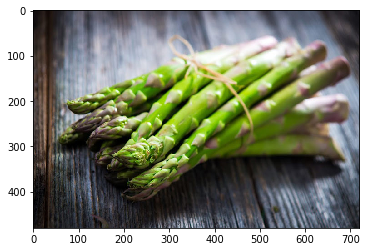

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show


def plot_images(image_augmentor):
    image_augmentor.fit(images)
    augmented_images = image_augmentor.flow(images)
    
    fig, rows = subplots(nrows=1, ncols=5, figsize=(18,18))
    for row in rows:
        row.imshow(augmented_images.next()[0].astype('int'))
        row.axis('off')
    show()
    
image = imread("asparagus2.jpg")

# Show the original image
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

imshow(images[0])
show()

###  Examples of images after Data Augmentation

#### Horizontal and Vertical Shift Augmentation

The ImageDataGenerator constructor control the amount of horizontal and vertical shift using the arguments The width_shift_range and height_shift_range respectively, a number of pixels can be specified to shift the image. 

A shift to an image means moving all pixels of the image in one direction, either horizontally or vertically, while keeping the image dimensions the same. The shift clips off some of the pixels from the image and there will be a region of the image where empty pixel values will have to be specified, by default the closest pixel value is chosen and repeated for all the empty values.


#### Horizontal Shift Augmentation

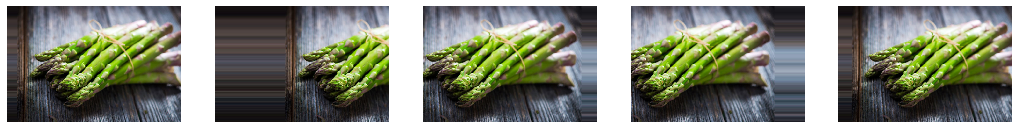

In [8]:
image_augmentor = ImageDataGenerator(width_shift_range=0.5)
plot_images(image_augmentor)

#### Vertical Shift Augmentation

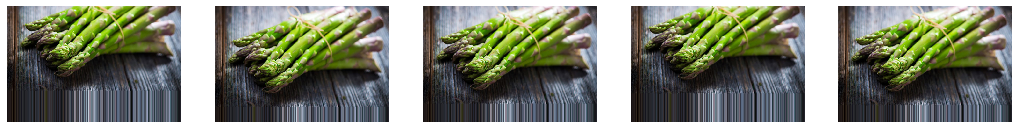

In [13]:
image_augmentor = ImageDataGenerator(height_shift_range=0.3)
plot_images(image_augmentor)

#### Horizontal and Vertical Flip Augmentation

An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

The flip augmentation is specified by a boolean horizontal_flip or vertical_flip argument to the ImageDataGenerator class constructor.

#### Horizontal Flip Augmentation

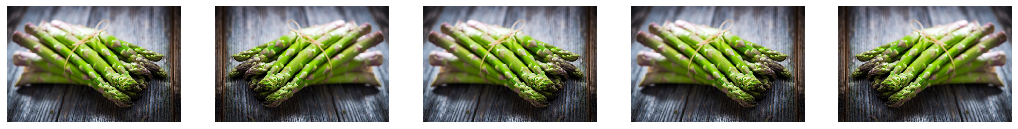

In [15]:
image_augmentor = ImageDataGenerator(horizontal_flip=True)
plot_images(image_augmentor)

#### Vertical Flip Augmentation

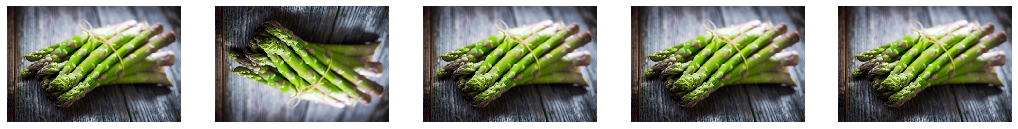

In [17]:
image_augmentor = ImageDataGenerator(vertical_flip=True)
plot_images(image_augmentor)

#### Rotation Augmentation
A rotation augmentation randomly rotates the image clockwise by a specified number of degrees from 0 to 360.
The rotation will likely rotate pixels out of the image frame and leave areas of the frame with no pixel data that must be filled in, by default the closest pixel value is chosen and repeated for all the empty values.

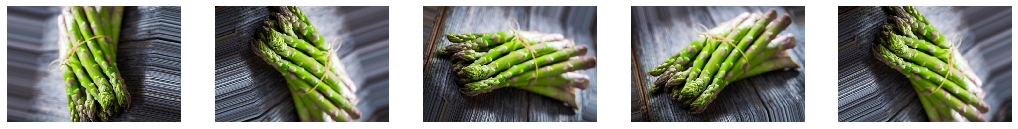

In [19]:
image_augmentor = ImageDataGenerator(rotation_range=90)
plot_images(image_augmentor)

#### Brightness Augmentation

The brightness of the image can be augmented by either randomly changing the brightness levels of the image.
generated images could be dark or light or both.

This helps the model to generalize across images captured in different lighting levels.
brightness_range argument is passed to the ImageDataGenerator() constructor that specifies min and max range as a floating point number representing the percentage for selecting the brightness levels.
1.0 has no effect on brightness, Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5].

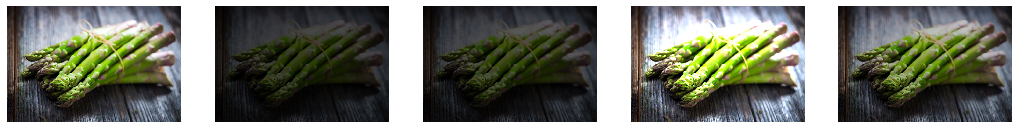

In [26]:
image_augmentor = ImageDataGenerator(brightness_range=(0.2, 1.5))
plot_images(image_augmentor)

#### Zoom Augmentation

Zoom augmentation randomly zooms the image in and out, either adds new pixel values around the image or interpolates pixel values respectively.

zoom_range argument is passed to the ImageDataGenerator constructor to enable Image zooming. You can specify the percentage of the zoom as a single float or a range.

If a float is specified, then the range for the zoom will be [1-value, 1+value]. 
For example, if you specify 0.3, then the range will be [0.7, 1.3], or between 70% (zoom in) and 130% (zoom out).

As seen below, random zoom in is different on both the width and height dimensions as well as the aspect ratio of the object in the image.

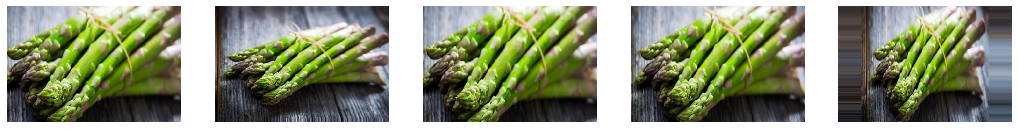

In [27]:
image_augmentor = ImageDataGenerator(zoom_range=[0.5, 1.5])
plot_images(image_augmentor)

**Data augmentation makes the model more robust to slight variations, and hence prevents the model from overfitting.**

Below we explore different effects of image augmentation and show below the effects of model performance:

## **Section 3: Base Model - ResNet Model Choice**

With the problem of image classification we understood that utilizing transfer learning would speed the training process. We chose to utilize the ResNet50 model due to its: 
- Accuracy proven on the ImageNet dataset
- Overall size (50 ReLu layers)

The ResNet50 dataset was trained on the ImageNet dataset which is a large volume dataset with classes associated with common everyday items (broccoli, horse, etc). Reviewing the categories the model has already been trained on, it currently doesn't have any that match the classes in our training dataset - however it has been trained on many plant and food related items. 

ResNet is a model built upon the Residual layer structure. It has been noted in literature where deeper networks tend to have lower accuracy compared to it's shallower counterpart. This is essentially because it can be hard for a dense layer to learn the y = x relationship when the training has become saturated. A Residual Layer has an impliminatation similar to  y = F(x) + x where the function F(x) can reduce to 0 and bypass the degradation problem. 

<table><tr>
    <td> <img src="ResidualLayer.JPG" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

Picture above is one layer of a residual layer which shows how the input can bypass the learned weights and become the output. This type of layer has shown high accuracy in image classification problems. He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Leraning for Image Recognition. Cornell University.


In addition to a well trained model we also needed to control the size and the inference time of the model. The intent of this paper is to train in a data center (where volume of data and computing power can be large) in order to bring the model to an edge device for inference. We therefore need to ensure the model is sufficiently small (such that the memory requirements won't exhaust the hardware of an edge device), fit on a limited storage device, and provide image inference at a reasonable time. Because of this constraint we chose to use ResNet50 as our baselayer vs ResNet 100, 1000 for example.

In [ ]:
# Load ResNet50 baseline model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

### Image Classification Model Analysis

In [4]:
import os
from glob import glob

IMAGECLASS_TRAIN_DIR = "train"
IMAGECLASS_VALIDATION_DIR = "validation"
IMAGECLASS_TEST_DIR = "test"

result = [y for x in os.walk(IMAGECLASS_TRAIN_DIR) for y in glob(os.path.join(x[0], '*.jpg'))]
classes = list(set([y.split("/")[-2] for y in result]))
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 32

### Train Data Generator

In [7]:
# Image augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

imageClass_train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=[0.5, 1.5],
    brightness_range=(0.1, 0.9)
    )

imageClass_train_generator = imageClass_train_datagen.flow_from_directory(IMAGECLASS_TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

Found 8000 images belonging to 70 classes.


### Validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using ImageDataGenerator.

In [8]:
imageClass_val_datagen = ImageDataGenerator(rescale=1./255)
imageClass_validation_generator = imageClass_val_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=IMAGECLASS_VALIDATION_DIR,
                                                 target_size=(HEIGHT, WIDTH),
                                                 class_mode='categorical')

Found 479 images belonging to 70 classes.


## **Section 4: Model Architecture - Predicting Plant Class**

Building on the baseline model, we have explored adding different layers (size, type, etc) in order to produce the 'best' performing model. See above and later discussions as to how we define 'best' model. For this paper we explored both accurately predicting the class of the plant in an image - which would help users understand more information about the specific plant they have taken the picture of, as well as predicting whether a plant is poisonous or not without the context of exact plant type. 

We first explored keeping all the base model layers static (no change to the model weights) and only training on the additional layers - we explore the following layer architecture: 
- Dense layers (different nodes and depths)
- CNN with pooling layers given the image classification problem
- Residual layer based on our chosen base model architecture

In order to narrow model choice we chose to train for 100 epochs on 15,000 images with a batch size of 64. Our specific trials are captured and analyzed below. Below we show the code that was used during model training (both for image classification as well as binary classification (poison yes/no)). Below the model architecture we detail performance of varying model architectures.

In [5]:
base_model.output.shape

TensorShape([Dimension(None), Dimension(10), Dimension(10), Dimension(2048)])

In [9]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
#     x = Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=base_model.output.shape)(x)
#     #x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(dropout)(x)
#     #x.add(Flatten())

# Add CNN
#     x = Conv2D(32, kernel_size=(3, 3),
#              activation='relu')(x)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

# Add Residual Layers
#     conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
#     conv2 = Conv2D(2048,(3,3), padding = 'same', activation = 'linear', kernel_initializer='he_normal')(conv1)
#     layer_out = add([conv2, x])
#     x = Activation('relu')(layer_out)
#     conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
#     conv2 = Conv2D(2048,(3,3), padding = 'same', activation = 'linear', kernel_initializer='he_normal')(conv1)
#     layer_out = add([conv2, x])
#     x = Activation('relu')(layer_out)
#     conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
#     conv2 = Conv2D(2048,(3,3), padding = 'same', activation = 'linear', kernel_initializer='he_normal')(conv1)
#     layer_out = add([conv2, x])
#     x = Activation('relu')(layer_out)
#     conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
#     conv2 = Conv2D(2048,(3,3), padding = 'same', activation = 'linear', kernel_initializer='he_normal')(conv1)
#     layer_out = add([conv2, x])
#     x = Activation('relu')(layer_out)
#     conv1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
#     conv2 = Conv2D(2048,(3,3), padding = 'same', activation = 'linear', kernel_initializer='he_normal')(conv1)
#     layer_out = add([conv2, x])
#     x = Activation('relu')(layer_out)

    x = Flatten()(x)
    for fc in fc_layers:
        # Can look here if adding different types of layers has an effect
        # Also explore differences in changing activation function
        # Can also iterate on droupout amount
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

# Can change the model architecture here
FC_LAYERS = [128,32]
dropout = 0.3

imageClass_finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(classes))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
import numpy   
    
# For the baseline model will use 100 epochs and 15000 images to test model performance
# Will then use 'optimized' model parameters to train for longer time and explore
# Size vs Accuracy for edge compute purposes
NUM_EPOCHS = 100
BATCH_SIZE = 64
num_train_images = 15000
num_val_images = 479

adam = Adam(lr=0.00001)
# Can look into whether 
#finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

imageClass_finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Checkpoin is overwritten at each epoch - can look at line below where datetime is used to create time based file names
filepath="/root/w251_finalproject/checkpoint/model"
checkpoint = ModelCheckpoint(filepath, monitor=["categorical_accuracy"], verbose=1, mode='max')


# history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
#                                        steps_per_epoch=num_train_images // BATCH_SIZE, 
#                                        shuffle=True)# , callbacks=[checkpoint])

imageClass_history = imageClass_finetune_model.fit_generator(
    imageClass_train_generator,
    steps_per_epoch= num_train_images // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=imageClass_validation_generator,
    validation_steps= num_val_images // BATCH_SIZE
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
250/250 [==============================] - 275s 1s/step - loss: 4.0240 - categorical_accuracy: 0.0878 - val_loss: 4.6113 - val_categorical_accuracy: 0.0021
Epoch 2/100
250/250 [==============================] - 257s 1s/step - loss: 3.5324 - categorical_accuracy: 0.1896 - val_loss: 4.4534 - val_categorical_accuracy: 0.0146
Epoch 3/100
250/250 [==============================] - 259s 1s/step - loss: 3.3367 - categorical_accuracy: 0.2323 - val_loss: 4.0701 - val_categorical_accuracy: 0.1065
Epoch 4/100
250/250 [==============================] - 255s 1s/step - loss: 3.2017 - categorical_accuracy: 0.2606 - val_loss: 3.9508 - val_categorical_accuracy: 0.1211
Epoch 5/100
250/250 [==============================] - 255s 1s/step - loss: 3.1179 - categorical_accuracy: 0.2804 - val_loss: 4.0411 - val_categorical_accuracy: 0.1148
Epoch 6/100
250/250 [==============================] - 255s 1s/step - loss: 2.9306 - categorical_accuracy: 0.321

In [12]:
# Save model performance in order to plot / compare later
numpy.savetxt('ImageClass_loss_history.txt', 
              numpy.array(imageClass_history.history['loss']), delimiter = ',')
numpy.savetxt('ImageClass_acc_history.txt', 
              numpy.array(imageClass_history.history['categorical_accuracy']), delimiter = ',')

## **Section 5: Image classification model Inference in VM before deploying to TX2**

The code below depicts the training run for the code provided above. The code base for both image classification (plant type) as well as binary classification (poison vs edible) is the same and won't be duplicated. The only differences between the two are the accuracy (categorical vs binary) - and the chosen optimum model. The following discussion details the training of an image classification model - followed by the binary model.

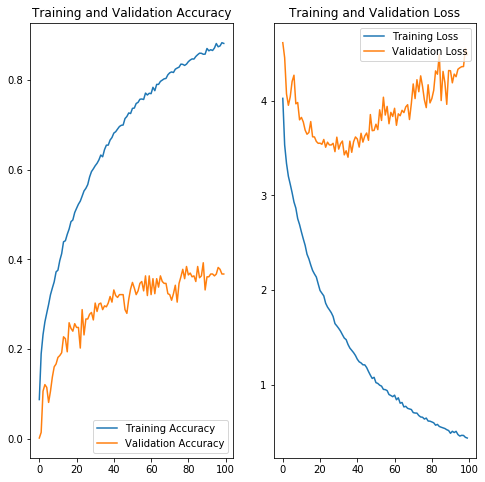

In [14]:
# Visualize model performance

import matplotlib.pyplot as plt
acc = imageClass_history.history['categorical_accuracy']
val_acc = imageClass_history.history['val_categorical_accuracy']

loss = imageClass_history.history['loss']
val_loss = imageClass_history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy and loss plots above suggest that we are potentially over-fitting our model towards the training dataset. We can see that high accuracy is achieved in the image classification - which is typically hard given the number of classes we are trying to predict. After 100 epochs we are achieving >90% accuracy on the training set, but <40% accuracy on the validation set. Additionally, validation accuracy appears to have plateaued at this level.

Similarly if we analyze the loss graph, we can see that loss is minimized for the validation dataset near 40 epochs and begins to rise - while the training loss continues to decrease. This structure was similar amongst the models that were analyzed using different layer and node architectures as well as activation functions. 

In the future we would like to:
- Change the dropout rate - perhaps 0.3 is too low and allows the deep model to over-fit
- Use larger datasets. Perhaps there is a feature contained within the image augmented photos that the model is fitting to - whereby the validation dataset doesn't have augmented photos. The purpose of image augmentation is to increase the training dataset size as well as improve model performance to a variety of photos. This will need further investigation to prove whether this assumption is true.

It should be noted that our best performance was found when we enabled training on the base model layers (ResNet50). Presumably the residual layer architecture helped improve training inference above and beyond what the additional layers on top of the base model could provide. While this did impact training time on the VM (~36sec per epoch vs ~24 sec/epoch) the increase is marginal. Since training is done offline (only model inference at the edge needs to be performant) the tradeoff in training time vs accuracy is worthwhile. 

While this model can further be optimized in order to increase validation accuracy - we understand that image classification - especially given the dataset similarity (all pictures of plants), can be difficult. We have chosen to move forward with this model which is lean (only uses 2 dense layers on top of the ResNet50 base model). This should help with model performance on the edge device. Future work will continue to improve model performance while also retaining a small network size. 

### Save Model for deployment

In [15]:
imageClass_finetune_model

In [16]:
os.makedirs('./model', exist_ok=True)
imageClass_finetune_model.save('./model/imageclass_model2.h5')

In [8]:
from keras import backend as K
import tensorflow as tf
from  tensorflow.python.keras.models import load_model
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

Using TensorFlow backend.


In [10]:
imageClass_model = load_model('./model/imageclass_model2.h5')

In [11]:
imageClass_model

In [12]:
imageClass_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

We can see that, even though we chose ResNet50 as the base model due to its size - there are still a number of parameters that are contained within our overall model (the model summariezed above allows training on many of the ResNet50 layers as this gave better accuracy). In the inference section we will detail model performance both with and without TensorRT optimization and show how a large model such as the one depicted above can be difficult on the resources provided at the edge.

In [13]:
print(imageClass_model.inputs)
print(imageClass_model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(?, 300, 300, 3) dtype=float32>]
[<tf.Tensor 'dense_2_1/Softmax:0' shape=(?, 70) dtype=float32>]


In [34]:
import numpy as np
#labels_path = tf.keras.utils.get_file('cats_dogs_labels.txt','http://localhost:8888/edit/cats_dogs/cats_dogs_labels.txt')
labels_path = 'Plant_Class_Labels.txt'
class_labels = np.array(open(labels_path).read().splitlines())
class_labels

array(['Alfalfa', 'Asparagus', 'Blue_Vervain', 'Broadleaf_Plantain',
       'Bull_Thistle', 'castor_oil_plant', 'Cattail', 'Chickweed',
       'Chicory', 'Cleavers', 'Coltsfoot', 'Common_Sow_Thistle',
       'Common_Yarrow', 'Coneflower', 'Creeping_Charlie',
       'Crimson_Clover', 'Curly_Dock', 'Daisy_Fleabane', 'Dandellion',
       'dieffenbachia', 'Downy_Yellow_Violet', 'Elderberry',
       'Evening_Primrose', 'Fern_Leaf_Yarrow', 'Field_Pennycress',
       'Fireweed', 'Forget_Me_Not', 'foxglove', 'Garlic_Mustard',
       'Harebell', 'Henbit', 'Herb_Robert', 'Japanese_Knotweed',
       'Joe_Pye_Weed', 'Knapweed', 'Kudzu', 'Lambs_Quarters', 'lilies',
       'lily_of_the_valley', 'Mallow', 'Mayapple', 'Meadowsweet',
       'Milk_Thistle', 'Mullein', 'New_England_Aster', 'oleander',
       'Partridgeberry', 'Peppergrass', 'Pickerelweed', 'Pineapple_Weed',
       'Prickly_Pear_Cactus', 'Purple_Deadnettle', 'Queen_Annes_Lace',
       'Red_Clover', 'rhubarb', 'Sheep_Sorrel', 'Shepherds_Pu

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGECLASS_TEST_DIR = "test"
image_generator = ImageDataGenerator(rescale=1/255)

image_data = image_generator.flow_from_directory(directory=IMAGECLASS_TEST_DIR,
                                                 target_size=(HEIGHT, WIDTH))

Found 157 images belonging to 70 classes.


In [29]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 300, 300, 3)
Label batch shape:  (32, 70)


In [51]:
result_batch = imageClass_model.predict(image_batch)
result_batch.shape

(32, 70)

In [52]:
predicted_class_names = class_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Vervain_Mallow', 'Daisy_Fleabane', 'Purple_Deadnettle',
       'Wild_Bee_Balm', 'lilies', 'Vervain_Mallow', 'Daisy_Fleabane',
       'Knapweed', 'Red_Clover', 'Toothwort', 'Meadowsweet', 'Knapweed',
       'rhubarb', 'Common_Sow_Thistle', 'Alfalfa', 'Wild_Leek', 'Alfalfa',
       'Elderberry', 'Wild_Bee_Balm', 'Fern_Leaf_Yarrow', 'Spring_Beauty',
       'Mallow', 'Wild_Bee_Balm', 'Asparagus', 'Joe_Pye_Weed',
       'Joe_Pye_Weed', 'Curly_Dock', 'Wood_Sorrel', 'Field_Pennycress',
       'dieffenbachia', 'Wood_Sorrel', 'Herb_Robert'], dtype='<U19')

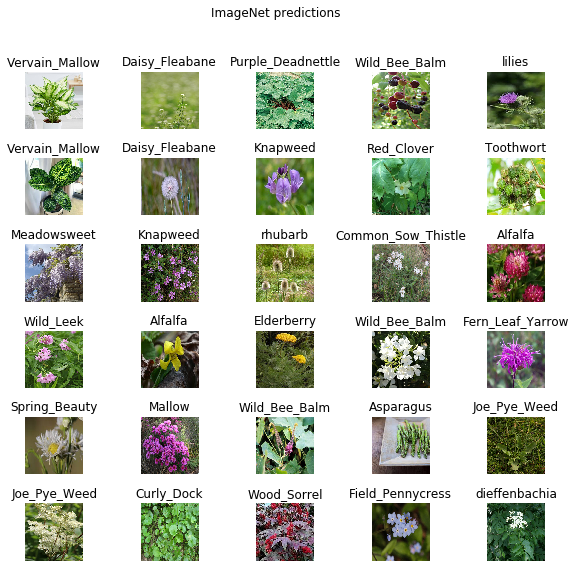

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In general many of the predicted image labels were correct. As can be seen above - the nuances in plant images in order to assign a class from over 70 total classes is a difficult problem. While our training accuracy gave good results - further model development will be needed in order to improve validation accuracy. 

As stated in the introduction - we understood that image classification was likely a difficult problem to obtain high accuracy. While it is optimal to have the specific plant species depicted in the photo (in order to not only obtain edible/poison information - but also plant background/and other facts), we also need to optimize the solution of whether the plant is edible or poisonous. Having <40% accuracy on the validation datset does not lend enoguh confidence to utlize the model at the edge if debating to eat a plant based on the model prediction. 

We therefore developed another model (binary model) in order to obtain higher accuracy to provide confidence to the user whether or not a plant is edible or poisonous. 

## **Section 6: Binary Poison Detection Model Analysis**

While having the ability to reveal plant identification via image classification provides a richer context of the plant background (name, species, description, etc) - we have seen that the model cannot predict with a high accuracy (>90%) whether or not a plant is poisonous. From a users perspective, this lack of confidence likely isn't worthwhile to utilize the model as the consequences of a wrong prediction are severe. 

In addition to the image classification problem described above we also explored whether or not features contained in the images of poisonous and edible plants could be extracted in order to predict whether or not a plant was poisonous (without regard to the specific species or genome of the plant). We similarly started with ResNet50 as this provides a good starting point for model architecture as well as the image classification problem. 

Similar to image classification - we attempted different model architectures in order to obtain the best performing model. In the first iteration of model performance we examined:
- Training on an imbalanced training set (remember we have >6k images of edible plants and only 410 of poisonous plants)
- Using image augmentation on the poisonous plants dataset in order to balance the training dataset
- Different model depths (baseline model contains layers with [128,64,32,16] nodes). Expanded to six different layers containing up to 1024 nodes. All layers were Dense in the original round of training
- Changing dropout rate - generally performed worse (perhaps needed longer training time) - performance not shown below
- Different activation functions (specifically tanh) 
- Training the entire model (including the ResNet50 base model)
- Different layer architecture (Dense, CNN, Pooling, Residual)

Depicted below is the performance of these different training episodes:
<table><tr>
    <td> <img src="Binary_Accuracy.JPG" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

In the legend, equal infers the training set is balanced, tanh refers to a different activation function (default was relu), trainentiremodel refers to un-freezing the base ResNet50 model for training. As can be seen, while certain model architecture changes did impact performance in the earlier training epochs - the best performing model by far was the model that trained all layers (including ResNet50) as well as having additional dense layers above. Presumably this showcases the improved accuracy that the residual layers have in terms of the image classification/detection problem over and above a series of dense layers. 

Surprisingly training the entire model did not have a large effect on training time. For 100 epochs training on only the dense layers we averaged 24sec per epoch training on a P100 GPU with a batch size of 64. When expanding and training on the entire model our average epoch time was 32sec. 

In terms of other model performance - there wasn't very much of a performance boost by equalizing the dataset. The blue and green lines show approximately similar performance across the training epochs. This is likely due to the image augmentation that's already taking place during training in order to increase our total image size to 15,000. Increasing the depth of the model didn't show significant model performance improvement. This may be due to a small change in overall model architecture - moving from a layer configuration of [128,64,32,16] to [512,256,128,64,32,16]. This also may be due to the aforementioned degradation problem with deeper networks. 

In order to explore different layer architectures - we also varied the types of layers as depicted below. Dense, CNN and Residual layers were all tested. During the early training periods we noticed that these different types of architectures likely required longer training periods to infer the appropriate weights. We therefore expanded our analysis to 500 epochs. 

As the training periods depicted above plateaued around 96% accuracy, we wanted to analyze whether different layers could produce better results. We attempted three different model architectures on top of the base ResNet50 model: 
- Dense layers: similar to what has previously been trained
- CNN layer with Pooling: has been shown to be useful for image classification and detection problems
- Residual layers (2): this is the model architecture for ResNet50 - we wanted to determine if a similar architecture would help improve model performance

<table><tr>
    <td> <img src="Binary_Accuracy_ModelLayer.JPG" alt="Drawing" style="width: 350px;"/> </td>
    <td> <img src="Binary_Precision_ModelLayer.JPG" alt="Drawing" style="width: 350px;"/> </td>
    <td> <img src="Binary_Recall_ModelLayer.JPG" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

As previously mentioned, accuracy isn't the only metric in which we need to track for the binary detection problem. While a accuracy of 100% would be phenomenal, it isn't likely. However we also need to be cognizant that a model that can predict 100% of the time correctly when there is a poisonous plant is very important. This is because the consequences of predicting a plant is poisonous when it isn't (false positive) is much less severe than predicting a plant is edible when it's poisonous (false negative). We therefore also track recall, precision and F1 scores. Of these scores recall is likely the most important since it tracks true positives vs the number of poisonous plants in the dataset. 

The graphs above depict accuracy, precision and recall in that order. In general all three match each other. From the plots we can see that CNN was the best performing model. The model that trained the entire ResNet50 along with two additional Residual layers may have outperformed - however the training time was significantly longer for this model. 

During validation testing we noted that overall performance was lower for many models compared to training accuracy ~50-85% compared to >90% on all models for training. This may be a consequence of over-fitting the model. We therefore attempted to train with a higher dropout (0.7 vs 0.3). As can be seen in the plots above this caused the model to fail to improve - perhaps because there was too much dropout. Further iterations would include refining the choice of dropout hyperparameter. Below is depicted a confusion matrix based on the final binary model: 

<table><tr>
    <td> <img src="ConfusionMatrix.JPG" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

We can see that overall performance on the validation dataset is fairly good (accuracy 97.5% and recall 100%). The biggest benefit is the recall is 100% - so in no case did the model predict an edible plant when it was in fact poisonous. 

While training it was noted that the best performing model in terms of training and validation accuracy & recall was using the model that enabled training for all layers and included an additional CNN + pooling layer, coupled with 4 additional dense layers. Future work may iterate over different nuanced design choices to develop the best performing model with the smallest footprint. This would not only hopefully help improve accuracy and recall - but also improve inference time and resources on the edge device. 

While this model architecutre is fairly large - we will use TensorRT in order to reduce the model size and improve inference. This is detailed in the sections below. 

## **Section 7: Inference on TX2 (Edge Device)**

Initially we wanted to see whether inference is possible on an edge device. We utilized a TX2 - which is more powerful than a typical edge device (smartphone / etc). When loading the model and attempting to make inference we found that most models wouldn't even load to memory. The larger model (detailed above with CNN and dense layers) frequently gave OOM errors indicating this model (without the benefit of TensorRT isn't applicable for edge devices). When the models would load we would frequently see nearly 100% memory utilization as depicted below:

<table><tr>
    <td> <img src="Memory_Inference2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

It is therefore important that we utilize TensorRT in order to improve model performance on lower powered edge devices. 

### TensorRT vs TensorFlow

In order to get the best inference performance on TX2, we utilized the TensorRT.

TensorRT is a platform that optimizes neural network models and speeds up for inference across GPU-accelerated platforms. It optimizes the neural network by the following way 1) eliminate the unused output layers to save the computation. 2) fuse the convolution layer, Relu layer and bias as one single layer 3) Aggregate the layers horizontally. It also leverages FP16 precision to lower the memory requirement on the GPU. It can go further to INT8 but it requires more calibartion when convert/freeze the model in TensorFlow while the precision is still FP32. For this exercise, we plan to use FP16. Others worth mentioning: better integrate with TensorFlow 2.0 (our model is under TensorFlow 1.x) and TensorBoard. And it only optimized from a freeze inteference graph. 

The benchmark on ResNet50 is that TensorRT is 8x faster than TensorFlow on interference.

### Convert Keras model to TensorFlow PB file
As first step, We will need to convert Keras model(.h5) to tensorflow pb file. at same time freeze the graph so that TensorRT can use that. The graph is a plan to excute the computation which covers varibles and connections.

Then we will be able to save the freeze model into PB file so that model can be loaded in TX2. The overall structure is detailed in the image below: 
<table><tr>
    <td> <img src="tensorrt.JPG" alt="Drawing" style="width: 750px;"/> </td>
</tr></table>


In [3]:
# Load model from .h5 file and convert to Tensorflow
# Adapted from https://github.com/ardianumam/Tensorflow-TensorRT
import tensorflow as tf
from keras import backend as K
tf.keras.backend.set_learning_phase(0)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def fbeta(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
# Load model without TensorRT improvement
from keras.models import load_model
filepath = './model_params/binary_equal_trainentiremodel_50kimage_300epoch_model_weights.h5' 

model = load_model(filepath, custom_objects={'precision': precision, 'recall':recall, 'f1':f1, 'fbeta':fbeta,
                                            'precision_m': precision_m, 'recall_m':recall_m})
model_name = filepath.split('/')[-1][:-3]
model_name

W1209 03:13:47.527824 548146294800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1209 03:13:47.644511 548146294800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1209 03:13:47.770972 548146294800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1209 03:13:47.774623 548146294800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1209 03:13:47.777615 54814629480

'binary_equal_trainentiremodel_50kimage_300epoch_model_weights'

### Convert keras model to Tensorflow and Save Frozen Graph

In [4]:
# import the needed libraries
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile


output_names = ['dense_15/Softmax']
input_names = ['input_2']


def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
    
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "../../model_params", "frozen_" + model_name + ".pb", as_text=False)


W1209 03:22:17.866091 548146294800 deprecation.py:323] From <ipython-input-4-1e01e96d2692>:36: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W1209 03:22:17.874302 548146294800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


'../../model_params/frozen_binary_equal_trainentiremodel_50kimage_300epoch_model_weights.pb'

### Optimize Using TensorRT

In [5]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

your_outputs = [out.op.name for out in model.outputs]
# convert (optimize) frozen model to TensorRT model
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,# frozen model
    outputs=your_outputs,
    max_batch_size=2,# specify your max batch size
    max_workspace_size_bytes=2*(10**9),# specify the max workspace
    precision_mode="FP32") # precision, can be "FP32" (32 floating point precision) or "FP16"

#write the TensorRT model to be used later for inference
with gfile.FastGFile("../../model_params/tensort_" + model_name + ".pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())
print("TensorRT model is successfully stored!")

W1209 03:38:16.449128 548146294800 deprecation.py:323] From <ipython-input-5-cc4bab4a24b5>:15: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


TensorRT model is successfully stored!


### Compare Models

In [6]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 2475
numb. of trt_engine_nodes in TensorRT graph: 59
numb. of all_nodes in TensorRT graph: 990


Above we can see that the model structure is smaller by utilizing tensorrt. This will help improve inference time on the edge device. 

### Inference on TX2

In [8]:
# import the needed libraries
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt # must import this although we will not use it explicitly
from tensorflow.python.platform import gfile
import numpy as np
import time
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img

img = load_img('roasted-asparagus-horiz-a-1600.jpg', target_size = (300,300))
input_img = np.expand_dims(img, axis = 0)

In [9]:
# function to read a ".pb" model 
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
  with gfile.FastGFile(model,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
  return graph_def

### TensorRT Model

In [11]:
# variable
TENSORRT_MODEL_PATH = "model_params/tensort_" + model_name + ".pb"

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
        # read TensorRT model
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input = sess.graph.get_tensor_by_name('input_1:0')
        output = sess.graph.get_tensor_by_name('dense_10/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
        avg_time_tensorRT = total_time / n_time_inference
        print("average inference time: ", avg_time_tensorRT)

needed time in inference-0:  0.27154040336608887
needed time in inference-1:  0.12302851676940918
needed time in inference-2:  0.11561846733093262
needed time in inference-3:  0.11101841926574707
needed time in inference-4:  0.1113739013671875
needed time in inference-5:  0.11808514595031738
needed time in inference-6:  0.11187052726745605
needed time in inference-7:  0.11685538291931152
needed time in inference-8:  0.10785388946533203
needed time in inference-9:  0.0915677547454834
needed time in inference-10:  0.11743283271789551
needed time in inference-11:  0.11315226554870605
needed time in inference-12:  0.11051702499389648
needed time in inference-13:  0.10962986946105957
needed time in inference-14:  0.11177444458007812
needed time in inference-15:  0.11580991744995117
needed time in inference-16:  0.1156463623046875
needed time in inference-17:  0.1150197982788086
needed time in inference-18:  0.11693429946899414
needed time in inference-19:  0.10866832733154297
needed time in

### Non Optimized Model

In [12]:
# variable
FROZEN_MODEL_PATH = "model_params/frozen_" + model_name + ".pb"

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(frozen_graph, name='')
        input = sess.graph.get_tensor_by_name('input_1:0')
        output = sess.graph.get_tensor_by_name('dense_10/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
        avg_time_original_model = total_time / n_time_inference
        print("average inference time: ", avg_time_original_model)
        print("TensorRT improvement compared to the original model:", avg_time_original_model/avg_time_tensorRT)

needed time in inference-0:  0.2708280086517334
needed time in inference-1:  0.14234304428100586
needed time in inference-2:  0.15391850471496582
needed time in inference-3:  0.1341855525970459
needed time in inference-4:  0.18431854248046875
needed time in inference-5:  0.15240883827209473
needed time in inference-6:  0.13216447830200195
needed time in inference-7:  0.13918542861938477
needed time in inference-8:  0.13611197471618652
needed time in inference-9:  0.310025691986084
needed time in inference-10:  0.13527488708496094
needed time in inference-11:  0.13274240493774414
needed time in inference-12:  0.13806581497192383
needed time in inference-13:  0.13801264762878418
needed time in inference-14:  0.13357114791870117
needed time in inference-15:  0.13676691055297852
needed time in inference-16:  0.13688015937805176
needed time in inference-17:  0.13867568969726562
needed time in inference-18:  0.14066481590270996
needed time in inference-19:  0.13436508178710938
needed time in

The above output shows that the tensorrt model has achieved moderate improvement in inference time compared to the non-optimized model. What isn't captured in these statistics however is the resource constraints that are required for inference and model loading. In both the cases where the model was loaded via keras load_model module as well as loading from a .pb graph file - the resource constraints were nearly maxed out for the edge device. 

The TensorRT optimized model did also require heavy resources - but more reliably ran the inference without crashing due to memory constraints. 

In a production environment we will: 
- Utilize a larger training dataset
- Train the model periodically in the cloud and compare performance
- Write the pb file and optimize using tensorrt on a cloud device
- Copy the pb file to an edge device for inference

During the testing on the edge - we have found that loading and infering with the tensorrt model provided the most stable inference environment. Further model reduction would be beneficial in order to improve performance on a lower powered device than the TX2. 

## **Section 8: Conclusion**

In this paper we successfully: 
- Used image augmentation to provide variety and bulk to the training dataset
- Utilized transfer learning in order to apply a base model (ResNet50) to a different dataset but similar problem
- Added to the model in order to learn the specific image classification tasks given our plant dataset
- Used different model architectures in order to balance accuracy and performance with model size
- Optimized the best performing model for inference at the edge
- Deployed to an edge device (TX2) and compared inference time along with discussion of memory/resource constraints

While our validation accuracy on the image classification problem was not optimal and requires additional model tuning and optimally larger dataset (with more classes/etc) in order to improve model performance. We did however achieve >97% accuracy on the binary model (poison vs edible) and in the validation dataset observed recall of 100% meaning there were no predictions that wrongfully predicted the plant was edible when it was in fact poisonous. 

The benefit of our model architecture is that it doesn't require a data network in order to upload an image to the cloud for inference - inference is achieved at the edge, something not achieved in the available plant identification apps/models. Our model sizes range from 100MB to 600MB so we must ensure both inference, resource and size constraints are met for lower powered devices. 

Future Work: Given the model architecture laid out in this paper - we would like to improve model performance by exploring the following: 
- Larger training set: the USDA has a plant dataset [https://plants.sc.egov.usda.gov/gallery.html]. We have scraped from this site and would like to train on this datset which contains >50k images and many more classes of plants found in the US
- Continue to optimize model performance and size - primarily in order to improve validation and test set performance
- Testing on lower powered edge devices. In this analysis we used a TX2 - however we would ideally like this model to be contained within an app for a smartphone so the user can take pictures with their device and determine the species of plant in the wild